# Basic Approach for Trace Clustering
## Kmeans + One Hot Encoding

Requirements:
- ~~implement basic approach (one-hot-enconding + kmeans)~~
- ~~hyperparameter experiments (grid-search)~~
- ~~interpretation of clusters (one municipal? etc.)~~
- ~~Notebook nicely presenting the clustering results for different hyperparameters~~

In [1]:
import pandas as pd

from practical.ProcessMining.group1.shared import utils
import pm4py
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.objects.conversion.log import converter as log_converter
from sklearn import metrics
from joblib import Parallel, delayed
import numpy as np
import os

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid

BASE = utils.SAMPLES_PATH
real_path = BASE / "DomesticDeclarations_cleansed.csv"
event_log_raw = utils.import_csv(BASE / "DomesticDeclarations_cleansed.csv")

In [2]:
def filter_rare_traces(log, threshold=2):
    case_counts = log.groupby('case:concept:name').size()
    frequent_traces = case_counts[case_counts >= threshold].index
    
    filtered_event_log = log[log['case:concept:name'].isin(frequent_traces)]
    return filtered_event_log

def split_by_date(log, date="2018"):
    date = pd.to_datetime(date).tz_localize('UTC')
    
    return log[log['time:timestamp'] < date], log[log['time:timestamp'] >= date]

def get_activities(log):
    return list(log['concept:name'].unique())

def get_df_by_traces(log):
    return log.groupby('case:concept:name')["concept:name"].apply(list).reset_index()

def hot_encode_traces(log, traces_df):
    traces = traces_df["concept:name"].to_list()
    all_activities = get_activities(log)
    
    # One-hot encode the event log
    one_hot_encoder = OneHotEncoder(sparse_output=False, categories=[all_activities], handle_unknown='ignore')
    one_hot_encoder.fit(np.array(all_activities).reshape(-1, 1))
    
    # Using dictionary comprehension to encode traces
    encoded_traces = [one_hot_encoder.transform(np.array(trace).reshape(-1, 1)).sum(axis=0) for trace in traces]
    
    # Stacking the encoded traces to form a sampled event log
    return np.vstack(encoded_traces)

def custom_metrics(log, _silhouette_score, weights=None):
    weights = {"ss": 0.4, "f": 0.25, "p": 0.35} if not weights else weights

    avg_fitness = 0
    avg_precision = 0
    
    sub_logs = split_by_cluster(log)
    
    for sub_log in sub_logs.values():
        petri_net, init_marking, final_marking = heuristics_miner.apply(sub_log)
        fitness = pm4py.conformance.fitness_alignments(sub_log, petri_net, init_marking, final_marking)["averageFitness"]
        precision = pm4py.conformance.precision_alignments(sub_log, petri_net, init_marking, final_marking)
        avg_fitness += fitness
        avg_precision += precision
        
    avg_fitness /= len(sub_logs)
    avg_precision /= len(sub_logs)

    return weights["ss"] * _silhouette_score + weights["f"] * avg_fitness + weights["p"] * avg_precision

def split_by_cluster(_event_log):
    _cluster_sublogs = {}
    for _cluster_label in np.unique(_event_log['cluster']):
        _cluster_sublogs[_cluster_label] = _event_log[_event_log['cluster'] == _cluster_label]
        
    _cluster_sublogs_sorted = dict(reversed(sorted(_cluster_sublogs.items(), key=lambda item: item[1]['case:concept:name'].nunique())))
    
    return _cluster_sublogs_sorted


def export_sublogs_to_csv(cluster_sublogs, folder="base_approach"):
    os.makedirs(folder, exist_ok=True)
    
    cluster_sublogs = {k: cluster_sublogs[k] for k in sorted(cluster_sublogs)}
    for cluster_label, df in cluster_sublogs.items():
        file_path = os.path.join(folder, f"cluster_{cluster_label}.csv")
        df.to_csv(file_path,sep=';',index=False)
    
    print(f"Clusters exported to /{folder}")


def version_print(i, description="Visualization"):
    if i == 0:
        name = "full span"
    elif i == 1:
        name = "from 2018"
    else:
        name = "before 2018"
    
    string = f"Version: {name} - Cluster {description}"
    separator = "=" * len(string)
    print("\n", separator, "\n", string)

## Event log preprocessing

As first step, we filter out rare traces, which are not appearing at least twice in the event log. This is done to avoid overfitting of the clustering algorithm.

Since we realized, that the event log contains event, which stopped appearing after 2018 (e.g. due to changes in the process), we split the event log into two parts: before 2018 and from 2018. In the end we compare the clusters of both versions as of the unsplitted log to see if the clustering algorithm can detect the change in the process.

In [3]:
event_log_preprocessed = filter_rare_traces(event_log_raw, threshold=2)

before_2018, from_2018 = split_by_date(event_log_preprocessed, "2018")
before_2018 = filter_rare_traces(before_2018, threshold=2)
from_2018 = filter_rare_traces(from_2018, threshold=2)

LOG_VERSIONS = [event_log_preprocessed, from_2018, before_2018]

## Event log sampling and encoding

To reduce the computational effort, we sample 1000 traces from the event log and encode them using one-hot-encoding.

In [4]:
event_log_sampled = event_log_preprocessed.sample(n=1000)

# Group traces by case and encode them as hole as one-hot vectors
traces = get_df_by_traces(event_log_sampled)

encoded_log = hot_encode_traces(event_log_preprocessed, traces)

## Parameter tuning for KMeans

To find the best hyperparameters for the KMeans clustering algorithm, we use a grid search approach. We evaluate the performance of each parameter combination using a custom metric, which is a combination of silhouette score, fitness and precision of the process model, while generalization and simplicity are intentionally discarded in score calculation.<br><br>
To reduce the computational effort, we parallelize the grid search and use a sample of the event log, created before.<br><br>
The best parameters are then used to cluster the original event log.

In [5]:
def param_grid_tuning(sample_log=event_log_sampled, _encoded_log=encoded_log, _traces=traces):
    # Apply KMeans clustering with hyperparameter tuning
    param_grid = {
        'n_clusters': [3, 4, 5, 6, 7],
        'init': ['k-means++', 'random'],
        'n_init': [10, 15, 20],
        'max_iter': [50, 100, 200],
    }
    
    score_weights = {"ss": 0.35, "f": 0.25, "p": 0.4}  # {"ss": 0.4, "f": 0.4, "p": 0.2} {"ss": 0.35, "f": 0.5, "p": 0.35}
    
    def evaluate_model(params, _encoded_log, _traces):
        test_log = sample_log.copy()  
        trace_df = _traces.copy()
        
        _k_means = KMeans(**params, random_state=42)
        _cluster = _k_means.fit_predict(_encoded_log)
        
        trace_df['cluster'] = _cluster        
        test_log = test_log.merge(trace_df[['case:concept:name', 'cluster']], on='case:concept:name', how='left')
        
        score = custom_metrics(
            log=test_log, 
            _silhouette_score=metrics.silhouette_score(_encoded_log, _cluster), 
            weights=score_weights)
        
        return score, params
            
    results = Parallel(n_jobs=-3)(delayed(evaluate_model)(params, _encoded_log, _traces) for params in ParameterGrid(param_grid))
    
    best_score, _best_params = max(results, key=lambda res: res[0])
    
    print(f"Best Score: {best_score}")
    print(f"Best Params: {_best_params}")
    
    return _best_params

best_params = param_grid_tuning(event_log_sampled, encoded_log, traces)

/Users/timedelmann/PycharmProjects/LMU_Process_Mining_SoSe24/venv/lib/python3.11/site-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]
/Users/timedelmann/PycharmProjects/LMU_Process_Mining_SoSe24/venv/lib/python3.11/site-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]
/Users/timedelmann

Best Score: 0.9383860889435034
Best Params: {'init': 'random', 'max_iter': 50, 'n_clusters': 7, 'n_init': 10}


aligning log, completed variants :: 100%|██████████| 5/5 [00:00<00:00, 564.78it/s]
computing precision with alignments, completed variants :: 100%|██████████| 2/2 [00:00<00:00, 1511.73it/s]
/Users/timedelmann/PycharmProjects/LMU_Process_Mining_SoSe24/venv/lib/python3.11/site-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]
aligning log, completed variants :: 100%|██████████| 3/3 [00:00<00:00, 768.61it/s]
computing precision with alignments, completed variants :: 100%|██████████| 2/2 [00:00<00:00, 3816.47it/s]
/Users/timedelmann/PycharmProjects/LMU_Process_Mining_SoSe24/venv/lib/python3.11/site-packages/pm4py/algo/discovery/dfg/adapters/

## Observations while implementation
#### Incremental improvements
1. Silhouette score calculation on original log was too time-consuming in combination with parameter tuning
2. To speed, used sample logs of actual eventlog and parallelized execution
3. Wrongly applied one-hot-encoding log wise not trace wise, which worked but led to wrong results
4. Switched from alpha miner to heuristic miner, since alpha miner created unsound models
5. Extended silhoutte score with alignment based fitness and precision to get more meaningful results, since silhouette score in combination with kmeans is not enough to evaluate the quality of the clusters
<br><br>

#### Parameter tuning results
- <b>init</b>: 'k-means++' is expected performing better than 'random' most of the time<br>
- <b>max_iter</b>: seems like lowest iterations always preferred. Kind of unexpected, initially started with 300 as smallest iteration, but even fulfilled for 3 as smallest value. "Set" to 50 as mid range value.<br>
- <b>n_cluster</b>: silhouette score calculates cluster affiliation, the more clusters are used, the better silhouette scores can be expected => overfitting problem, the more clusters, the better the score while cluster <= eventlog-unique-activities<br>
<br><br>

#### Best score range
- 0.92 - 0.96
<br><br>

#### None observed parameter/bestScore correlation
- 'n_init': but often lowest value

## Apply best parameters to original event Log

Next, using best parameters found for sample log to cluster the real log and add the cluster as column to the eventlog

In [6]:
def apply_kmeans(params, _event_log=event_log_preprocessed, _traces=traces):
    k_means = KMeans(**params, random_state=42)
    _traces = get_df_by_traces(_event_log)
    
    _encoded_log = hot_encode_traces(_event_log, _traces)
    _cluster = k_means.fit_predict(_encoded_log)
    
    _traces['cluster'] = _cluster
    
    return _event_log.merge(_traces[['case:concept:name', 'cluster']], on='case:concept:name', how='left'), _cluster

event_log, cluster_labels = apply_kmeans(best_params, event_log_preprocessed, traces)
cluster_sublogs = split_by_cluster(event_log)

## Plotting of Sublogs

To get an overview of the clusters, we plot the trace sizes and event distributions of each cluster.

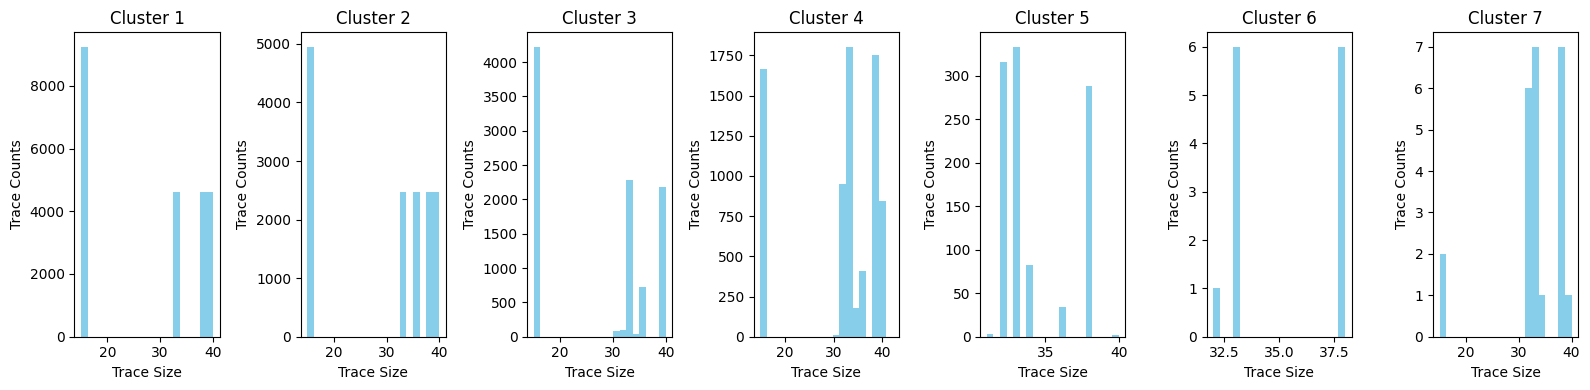

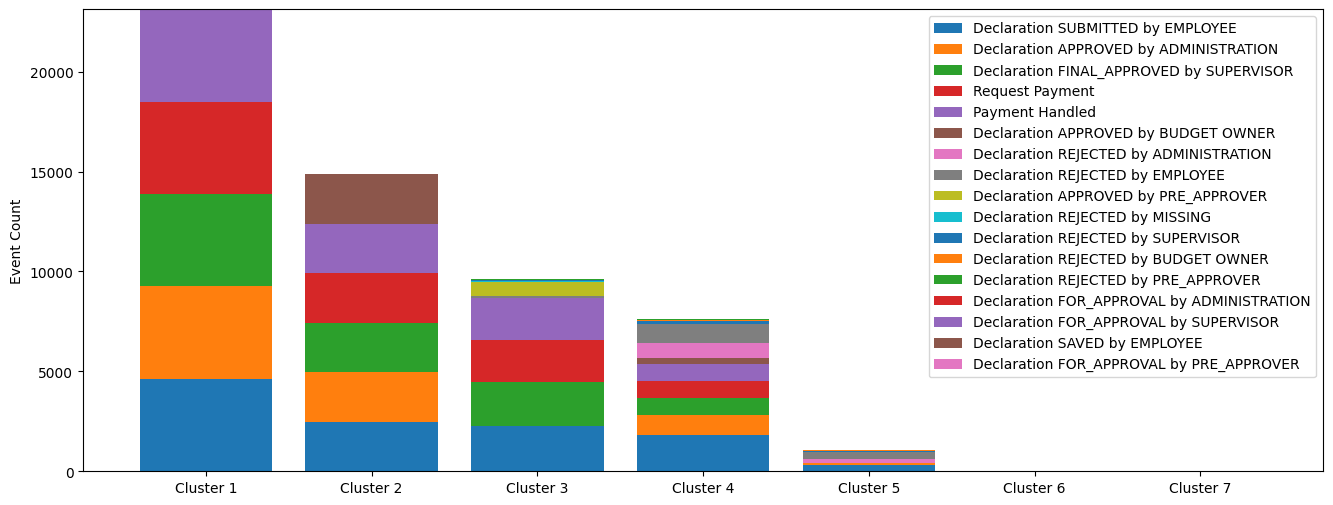

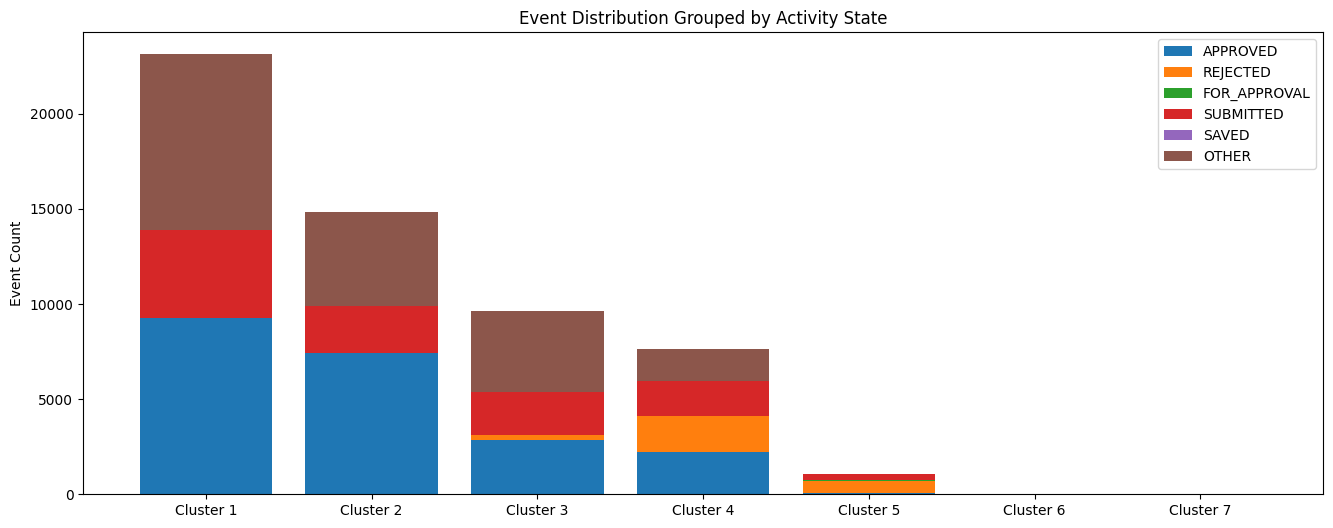

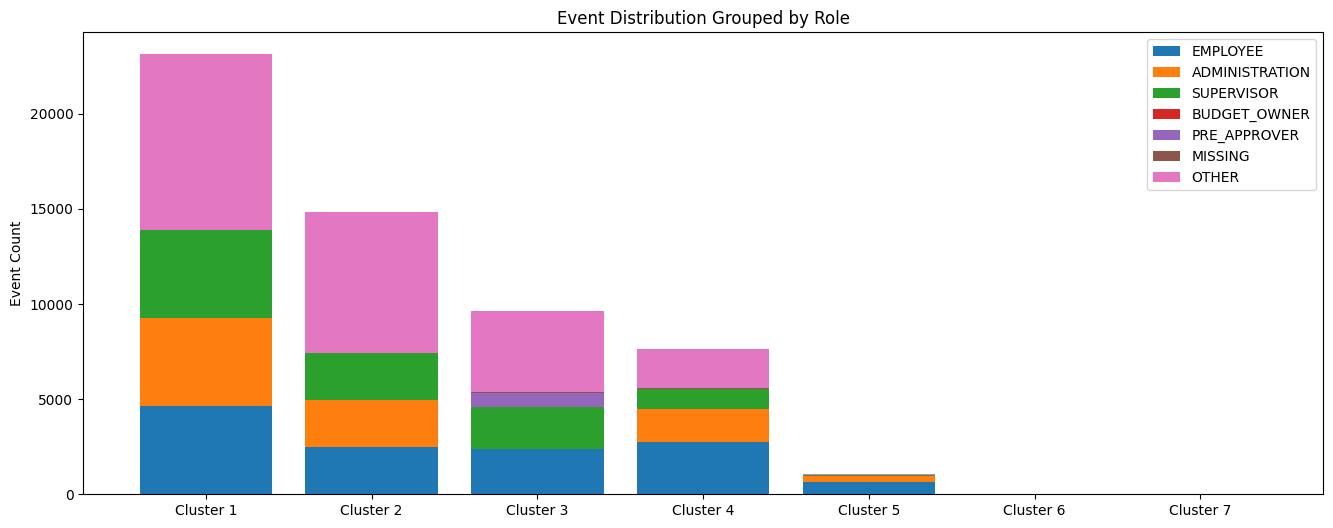

In [7]:
import matplotlib.pyplot as plt

def get_events_per_cluster(clusters, event_types):
    return [{event: sum(trace.count(event) for trace in cluster['concept:name']) for event in event_types} for cluster in clusters]

def plot_trace_sizes(clusters):
    plt.figure(figsize=(16, 4))
    for i, cluster in enumerate(clusters):
        trace_sizes = [len(trace) for trace in cluster['concept:name']]
        plt.subplot(1, len(clusters), i+1)
        
        plt.hist(trace_sizes, bins=20, color='skyblue')
        plt.title(f'Cluster {i+1}')
        plt.xlabel('Trace Size')
        plt.ylabel('Trace Counts')
    plt.tight_layout()
    plt.show()

def plot_event_distribution(clusters, event_types):
    events_per_cluster = get_events_per_cluster(clusters, event_types)
    
    plt.figure(figsize=(16, 6))
    bottom = np.zeros(len(clusters))
    for event in event_types:
        counts = [cluster[event] for cluster in events_per_cluster]
        plt.bar(range(len(clusters)), counts, bottom=bottom, label=event)
        bottom += np.array(counts)
    plt.xticks(range(len(clusters)), labels=[f'Cluster {i+1}' for i in range(len(clusters))])
    plt.ylabel('Event Count')
    plt.legend()
    plt.show()

def plot_event_group_distribution(clusters, event_types, groups, title):
    events_per_cluster = get_events_per_cluster(clusters, event_types)
    groups = group_events_types(groups, event_types)
    
    plt.figure(figsize=(16, 6))
    bottom = np.zeros(len(clusters))
    for group, events in groups.items():
        counts = [sum(cluster[event] for event in events if event in cluster) for cluster in events_per_cluster]
        plt.bar(range(len(clusters)), counts, bottom=bottom, label=group)
        bottom += np.array(counts)
    plt.xticks(range(len(clusters)), labels=[f'Cluster {i+1}' for i in range(len(clusters))])
    plt.ylabel('Event Count')
    plt.title(f'Event Distribution Grouped by {title}')
    plt.legend()
    plt.show()

# Assuming function to calculate event distribution
def calculate_event_distribution(log):
    event_distribution = {}
    for trace in log:
        for event in trace:
            if event not in event_distribution:
                event_distribution[event] = 0
            event_distribution[event] += 1
    return event_distribution

def group_events_types(groups, event_types):
    for event in event_types:
        found = False
        for key in groups.keys():
            if key in event:
                groups[key].append(event)
                found = True
                break
        if not found:
            groups["OTHER"].append(event)
    return groups


clusters = list(cluster_sublogs.copy().values())
event_types = get_activities(event_log)
STATES = {"APPROVED": [], "REJECTED": [], "FOR_APPROVAL": [], "SUBMITTED": [], "SAVED": [], "OTHER": []}
ROLES = {"EMPLOYEE": [], "ADMINISTRATION": [], "SUPERVISOR": [], "BUDGET_OWNER": [], "PRE_APPROVER": [], "MISSING": [], "OTHER": []}


plot_trace_sizes(clusters)
plot_event_distribution(clusters, event_types)
plot_event_group_distribution(clusters, event_types, STATES, "Activity State")
plot_event_group_distribution(clusters, event_types, ROLES, "Role")

## File Export

Finally, we split the modified log by cluster label and save each sublog to a csv file, which can be used for further analysis.

In [8]:
export_sublogs_to_csv(cluster_sublogs)

Clusters exported to /base_approach


## Petrinet Visualization of Sublogs

To visualize our result, we use pm4py heuristic miner and task4 vizualizer implementation to visualize created sub models.

replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/14 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

23121 events, 4624 cases


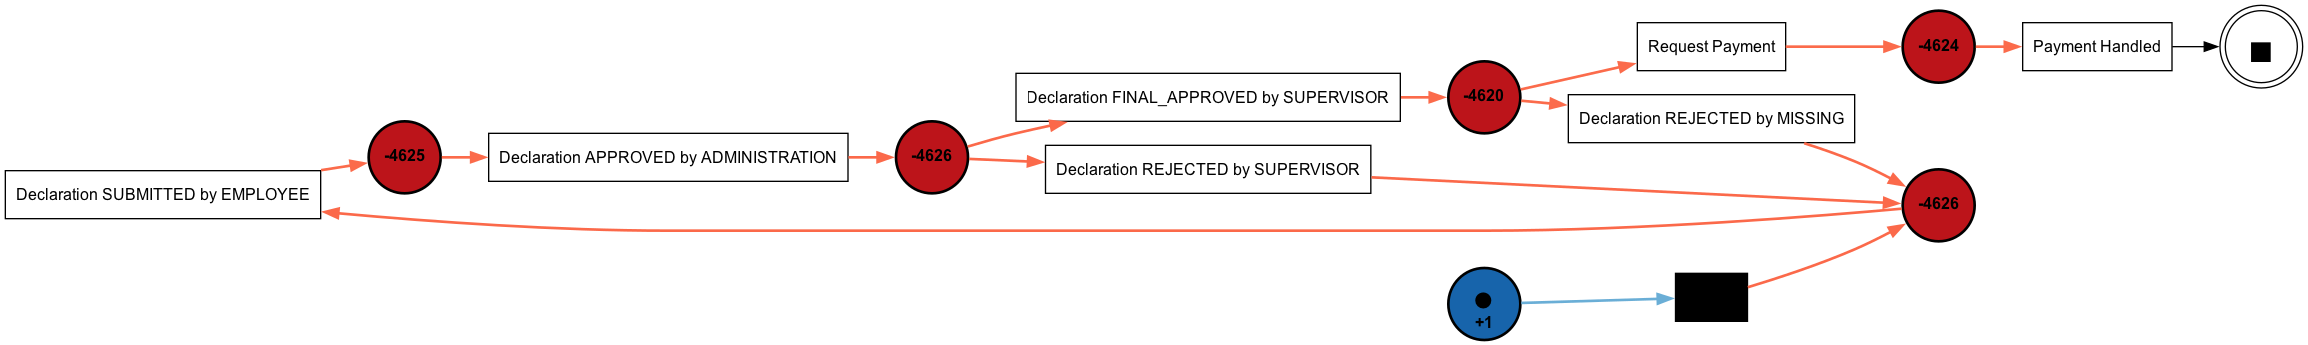

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/13 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

14858 events, 2476 cases


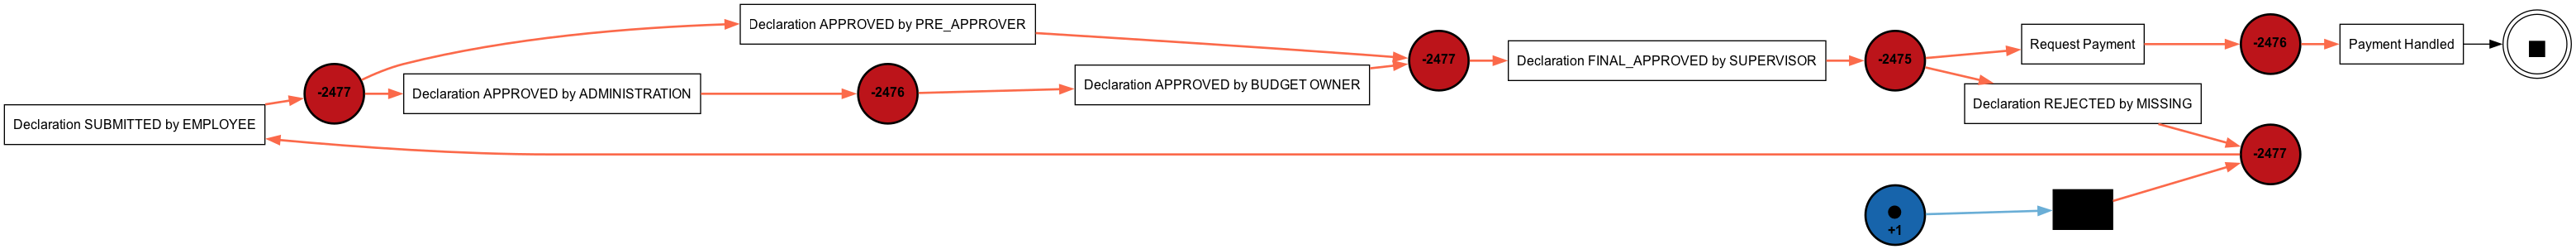

replaying log with TBR, completed traces ::   0%|          | 0/16 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/46 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/16 [00:00<?, ?it/s]

9622 events, 2137 cases


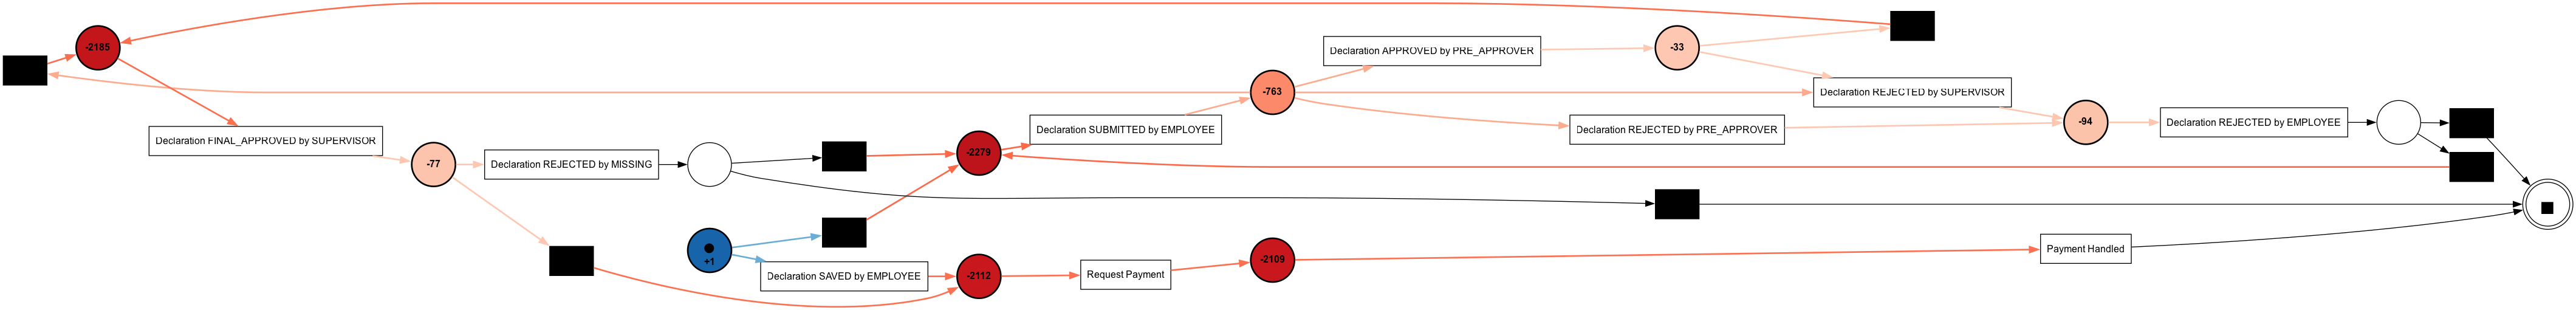

replaying log with TBR, completed traces ::   0%|          | 0/46 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/255 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/46 [00:00<?, ?it/s]

7608 events, 834 cases


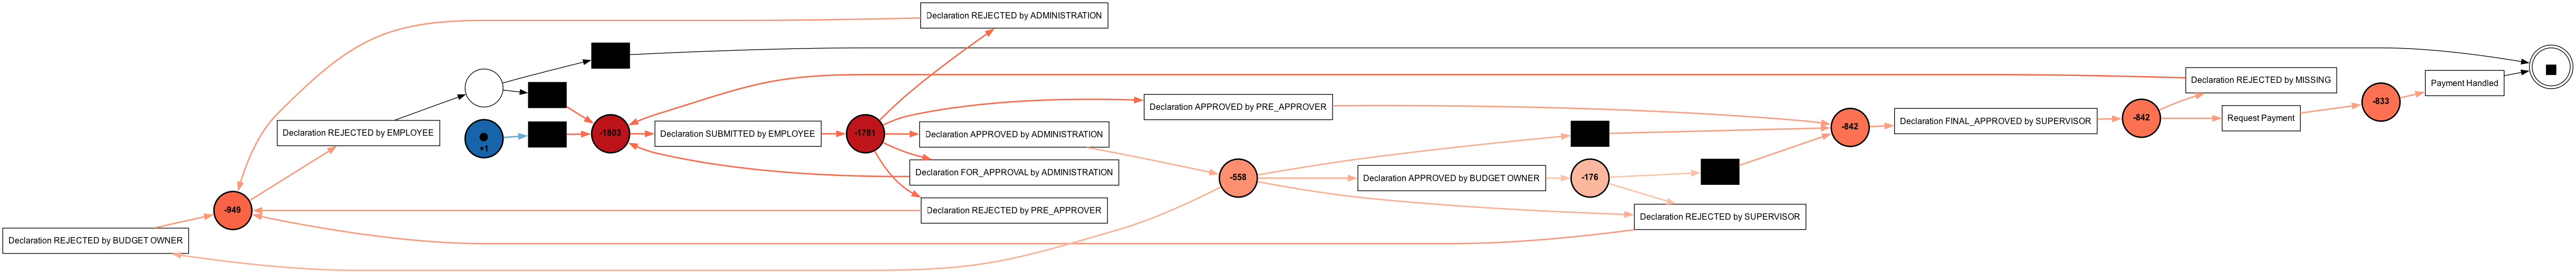

replaying log with TBR, completed traces ::   0%|          | 0/27 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/46 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/27 [00:00<?, ?it/s]

1057 events, 293 cases


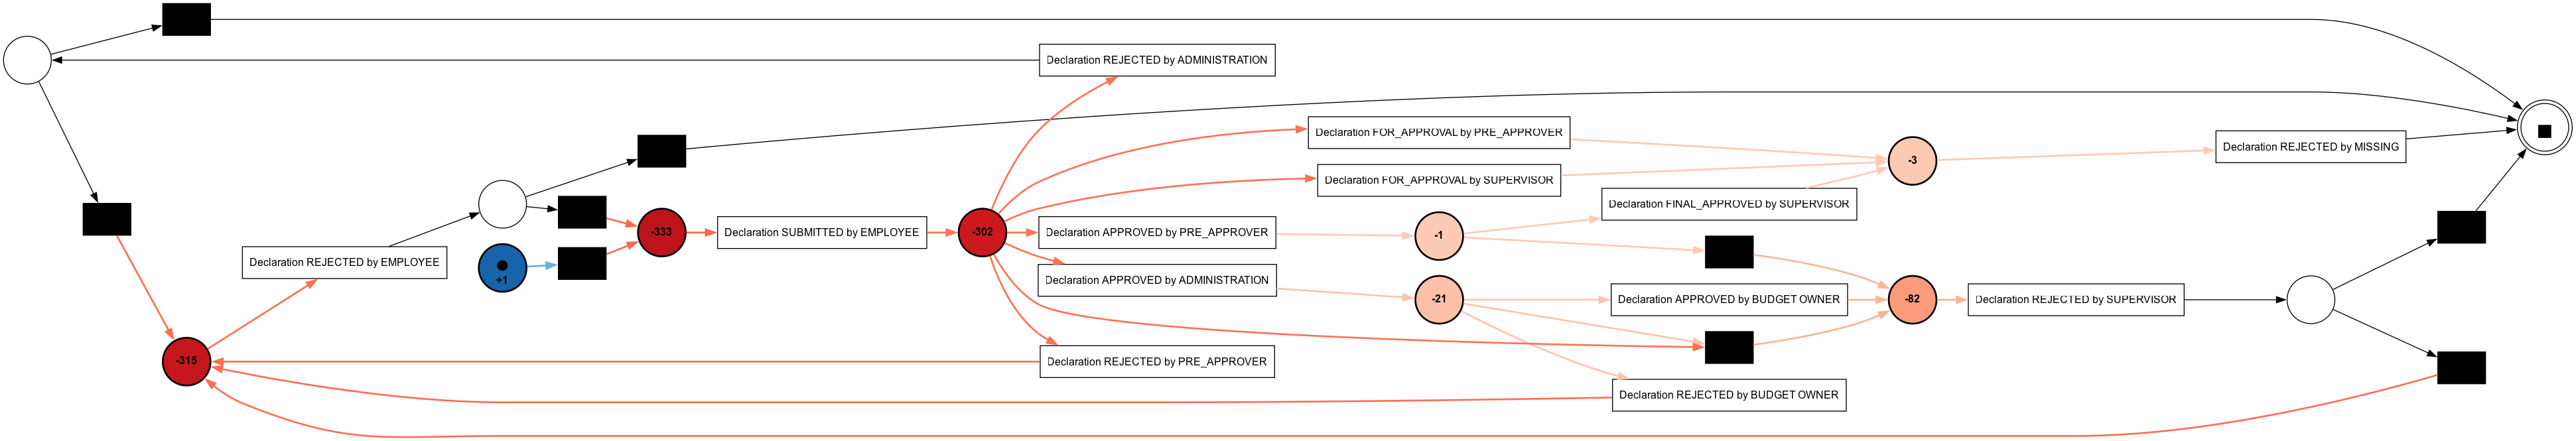

replaying log with TBR, completed traces ::   0%|          | 0/12 [00:00<?, ?it/s]

13 events, 1 cases


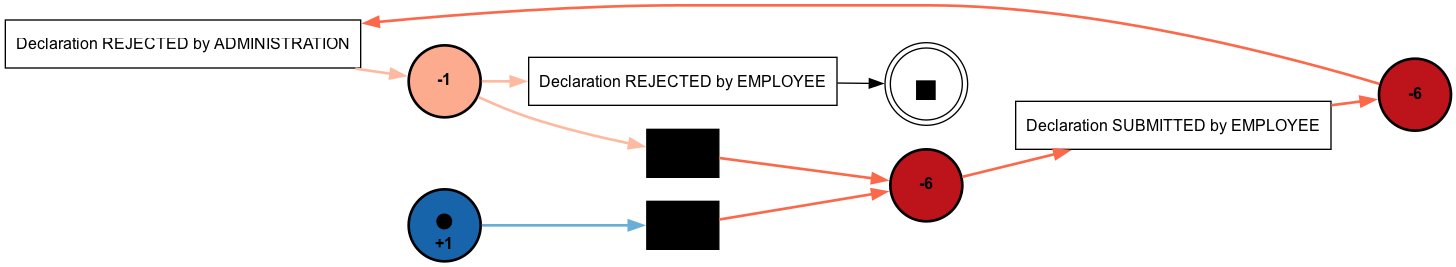

replaying log with TBR, completed traces ::   0%|          | 0/23 [00:00<?, ?it/s]

24 events, 1 cases


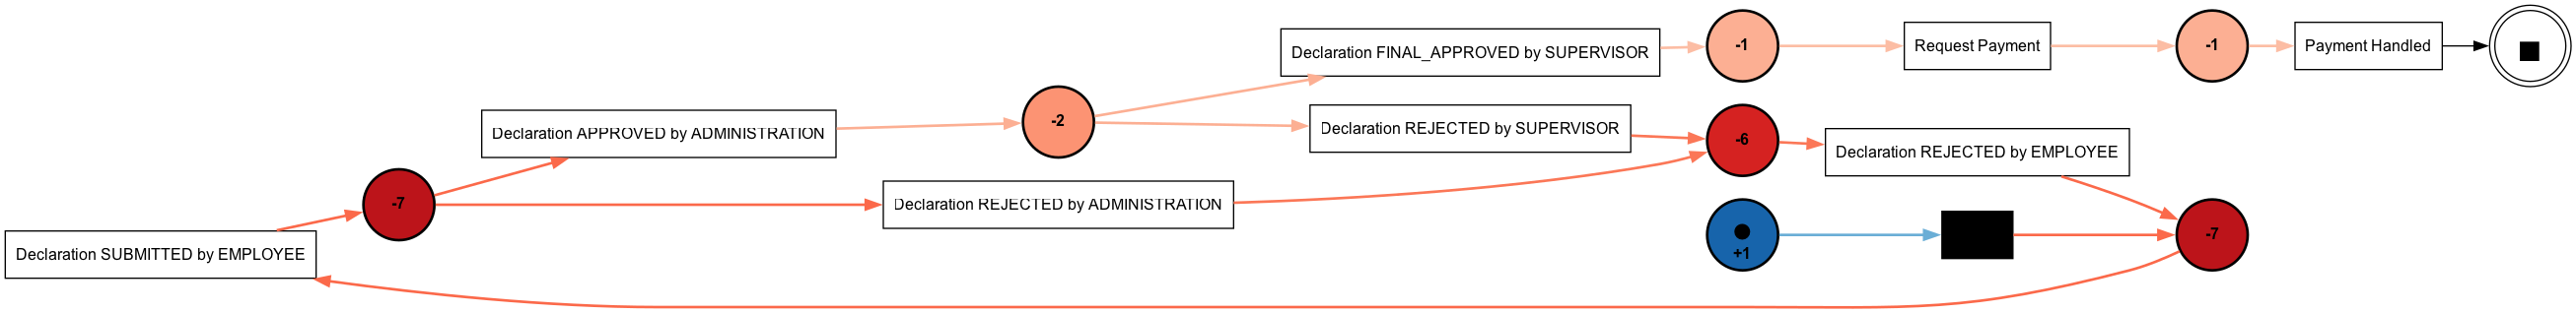

In [9]:
from practical.ProcessMining.group1.shared.visualizer import Visualizer
from practical.ProcessMining.group1.task4.tokenreplay import TokenReplay

def visualize_single_log(_cluster, df):
    _event_log = log_converter.to_event_log.apply(df)
    
    net, init, final = heuristics_miner.apply(_event_log)

    heuristics_miner_replay = TokenReplay(_event_log, net, init, final, "Heuristic Miner")

    heuristics_miner_replay.run(_event_log)
    tokens = heuristics_miner_replay.get_unconformity_tokens()

    vizard = Visualizer()
    graph = vizard.build_petri_net(net, init, final, tokens)
    print(f'{df.shape[0]} events, {df["case:concept:name"].unique().shape[0]} cases')

    vizard.display(graph)

def visualize_sublogs(_cluster_sublogs):
    for cluster_label, df in _cluster_sublogs.items():
        visualize_single_log(cluster_label, df)

visualize_sublogs(cluster_sublogs)

# Log Version Comparison

To compare the clustering results of the different versions of the event log, we visualize the clusters of each version side by side.
The clusters are sorted by the number of traces in each cluster, but there is no guarantee that the same cluster in different versions has the same label.


In [15]:
pre = event_log_preprocessed.sample(n=5000)
before, after = split_by_date(pre, "2018")
before = filter_rare_traces(before, threshold=2)
after = filter_rare_traces(after, threshold=2)
LOG_VERSIONS = [pre, after, before]

In [16]:
step0 = []
for log in LOG_VERSIONS:
    traces = get_df_by_traces(log)
    log_encoded = hot_encode_traces(log, traces)
    
    step0.append({"sample": log, "encoded": log_encoded, "traces": traces})

step1 = []
for i, log in enumerate(LOG_VERSIONS):
    best_params = param_grid_tuning(sample_log=step0[i]["sample"], _encoded_log=step0[i]["encoded"], _traces=step0[i]["traces"])
    step1.append(best_params)

/Users/timedelmann/PycharmProjects/LMU_Process_Mining_SoSe24/venv/lib/python3.11/site-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]
/Users/timedelmann/PycharmProjects/LMU_Process_Mining_SoSe24/venv/lib/python3.11/site-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]
/Users/timedelmann

Best Score: 0.8534715868973493
Best Params: {'init': 'k-means++', 'max_iter': 100, 'n_clusters': 6, 'n_init': 15}


/Users/timedelmann/PycharmProjects/LMU_Process_Mining_SoSe24/venv/lib/python3.11/site-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]
/Users/timedelmann/PycharmProjects/LMU_Process_Mining_SoSe24/venv/lib/python3.11/site-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]
/Users/timedelmann

Best Score: 0.6878024591066483
Best Params: {'init': 'random', 'max_iter': 50, 'n_clusters': 7, 'n_init': 10}


/Users/timedelmann/PycharmProjects/LMU_Process_Mining_SoSe24/venv/lib/python3.11/site-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]
/Users/timedelmann/PycharmProjects/LMU_Process_Mining_SoSe24/venv/lib/python3.11/site-packages/pm4py/algo/discovery/dfg/adapters/pandas/df_statistics.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]
/Users/timedelmann

Best Score: 0.719829556176451
Best Params: {'init': 'k-means++', 'max_iter': 50, 'n_clusters': 6, 'n_init': 10}


aligning log, completed variants :: 100%|██████████| 6/6 [00:00<00:00, 353.54it/s]
computing precision with alignments, completed variants :: 100%|██████████| 4/4 [00:00<00:00, 1870.79it/s]


In [17]:
step2 = []
for i, log in enumerate(LOG_VERSIONS):
    event_log, cluster_labels = apply_kmeans(params=step1[i], _event_log=log, _traces=step0[i]["traces"])
    step2.append({"event_log": event_log, "cluster": cluster_labels})
    
step3 = []
for i, log in enumerate(LOG_VERSIONS):
    cluster_sublogs = split_by_cluster(_event_log=step2[i]["event_log"])
    step3.append({"sublogs": cluster_sublogs, "clusters": list(cluster_sublogs.copy().values()), "event_types": get_activities(step2[i]["event_log"])})


 Version: full span - Cluster Trace Sizes


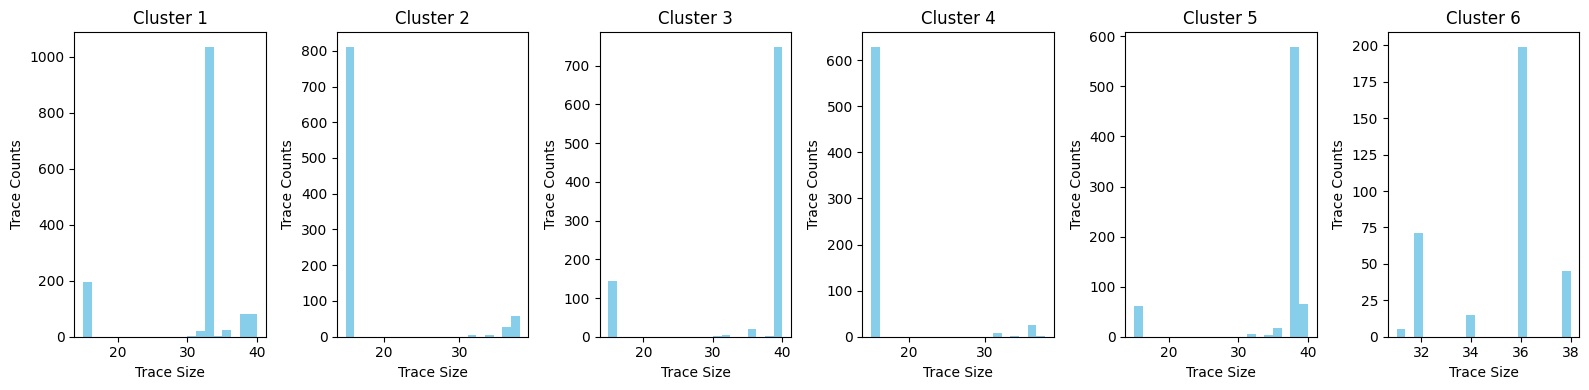


 Version: from 2018 - Cluster Trace Sizes


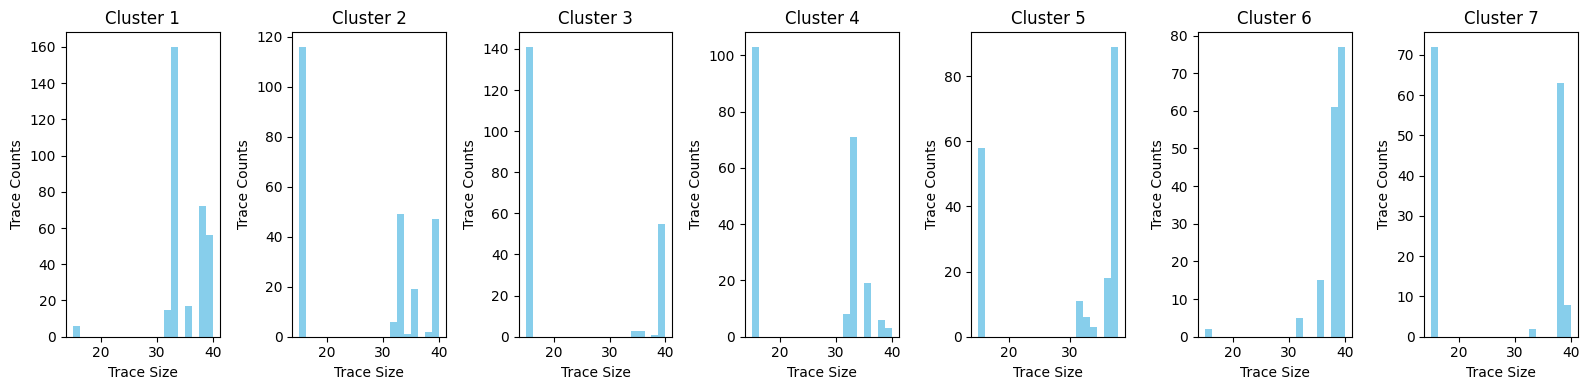


 Version: before 2018 - Cluster Trace Sizes


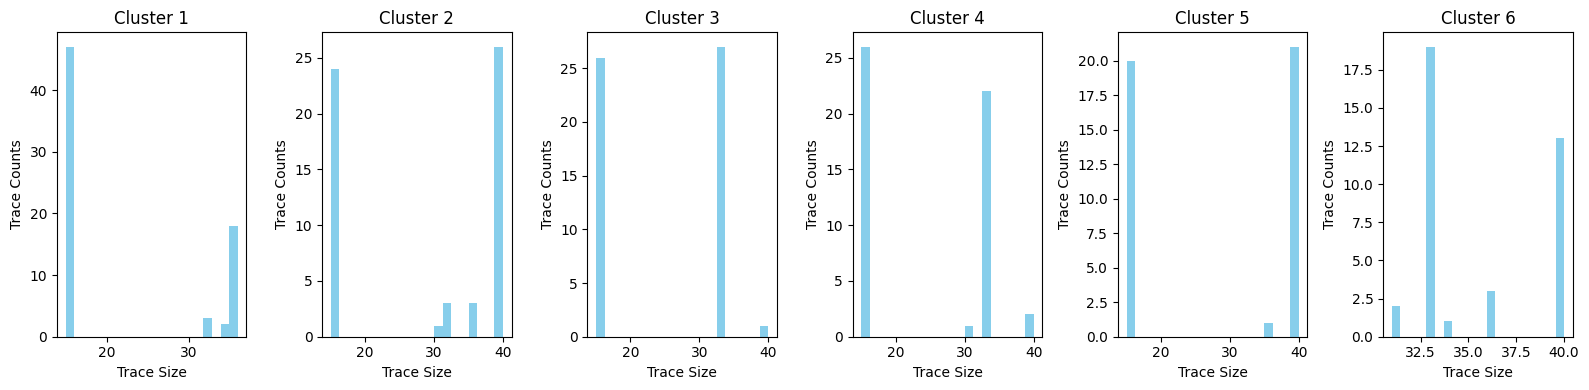









 Version: full span - Cluster Event Distribution by Activity States


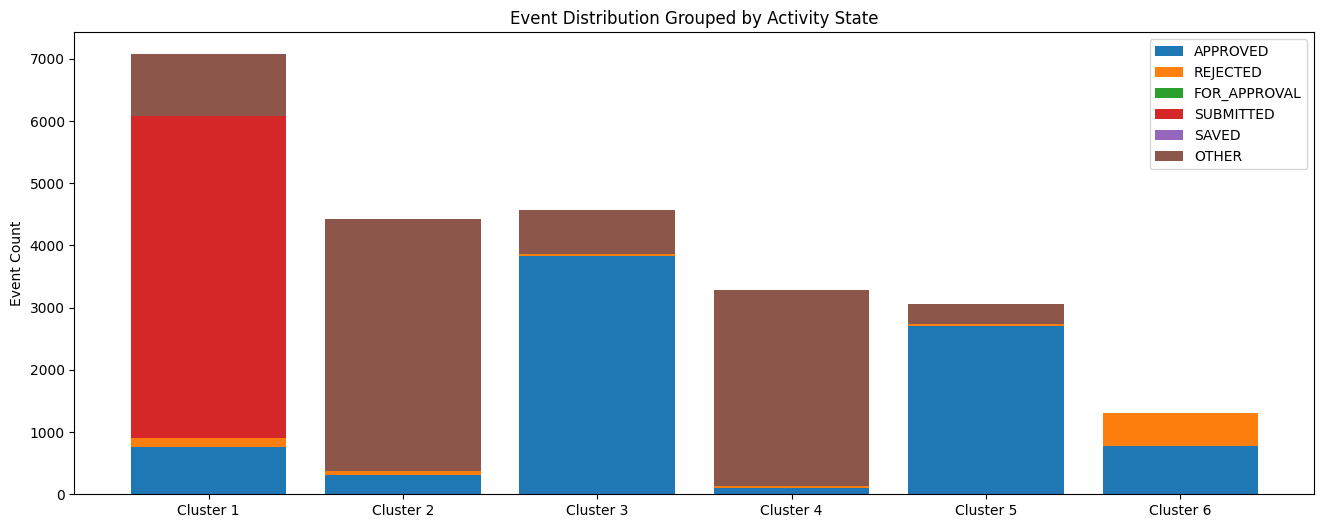


 Version: from 2018 - Cluster Event Distribution by Activity States


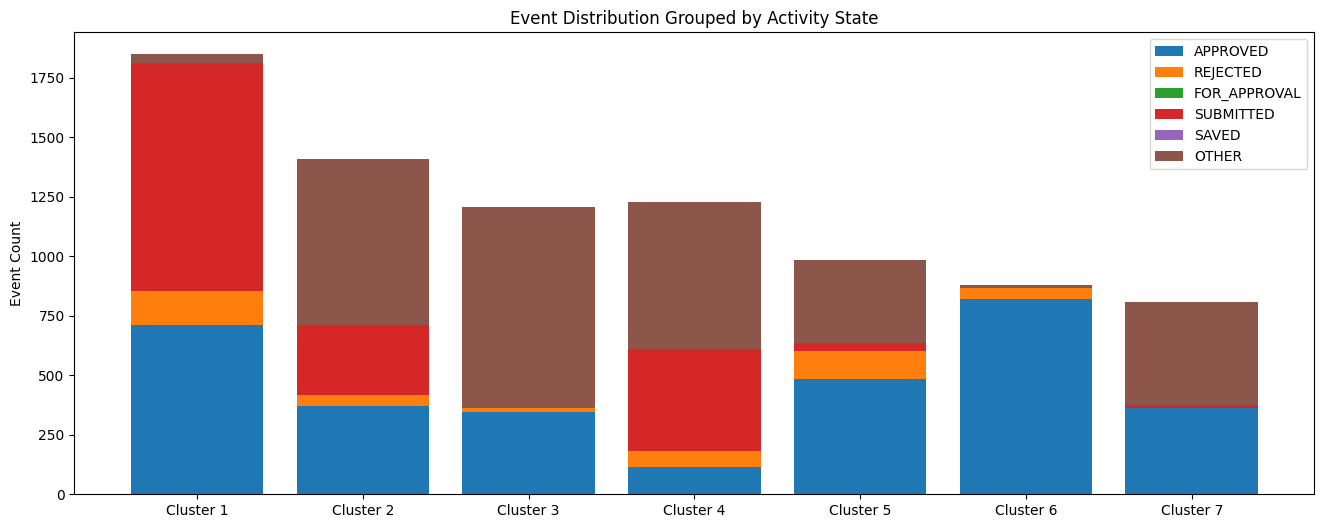


 Version: before 2018 - Cluster Event Distribution by Activity States


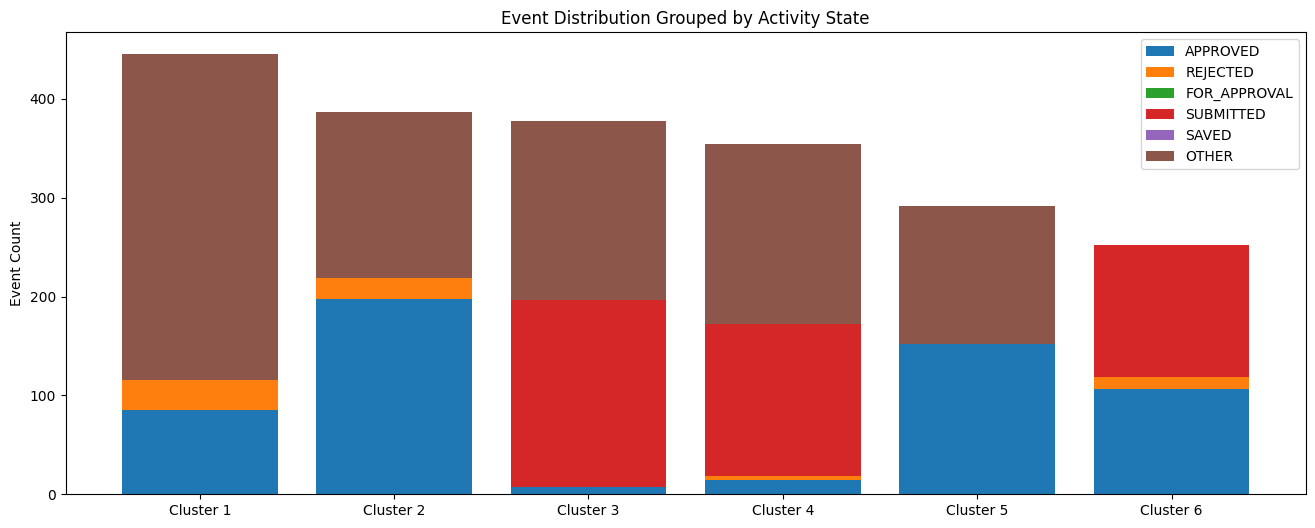









 Version: full span - Cluster Event Distribution by Roles


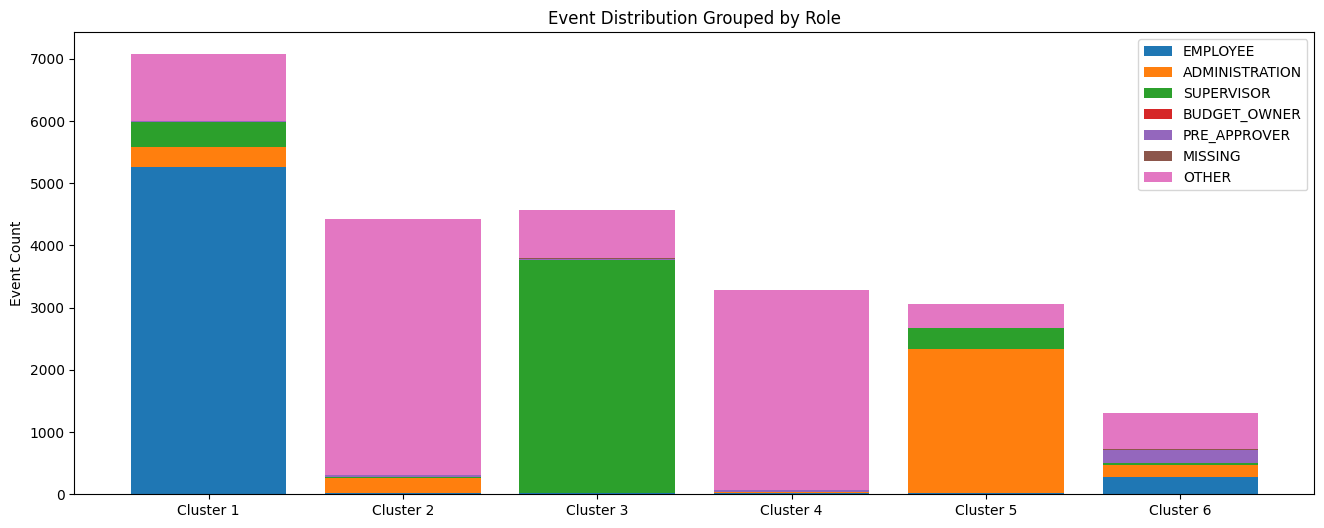


 Version: from 2018 - Cluster Event Distribution by Roles


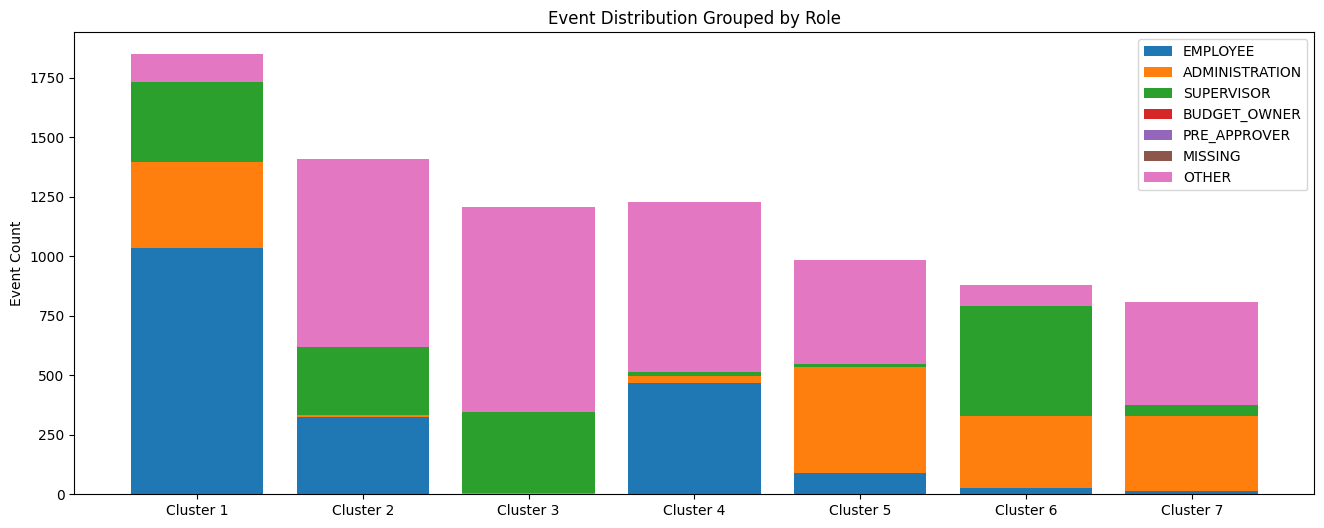


 Version: before 2018 - Cluster Event Distribution by Roles


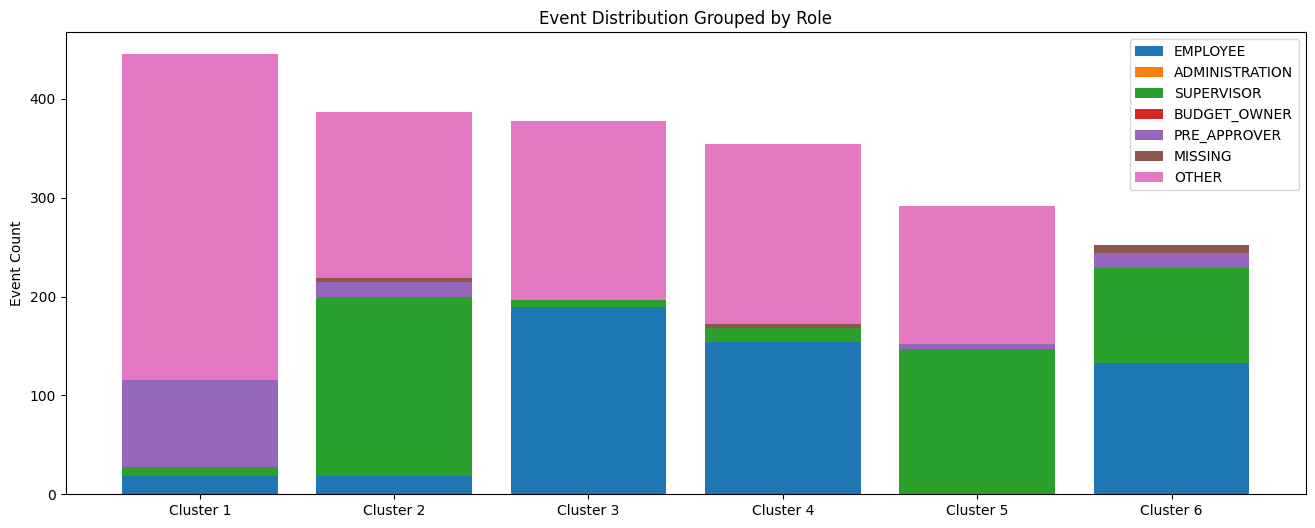

In [18]:
# Plotting
for i, log in enumerate(LOG_VERSIONS):
    version_print(i, "Trace Sizes")
    plot_trace_sizes(step3[i]["clusters"])
print("\n\n\n\n\n\n")
    
for i, log in enumerate(LOG_VERSIONS):
    version_print(i, "Event Distribution by Activity States")
    plot_event_group_distribution(step3[i]["clusters"], step3[i]["event_types"], STATES, "Activity State")
print("\n\n\n\n\n\n")
    
for i, log in enumerate(LOG_VERSIONS):
    version_print(i, "Event Distribution by Roles")
    plot_event_group_distribution(step3[i]["clusters"], step3[i]["event_types"], ROLES, "Role")
print("\n\n\n\n\n\n")


 Version: full span - Cluster 1


replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

219 events, 219 cases


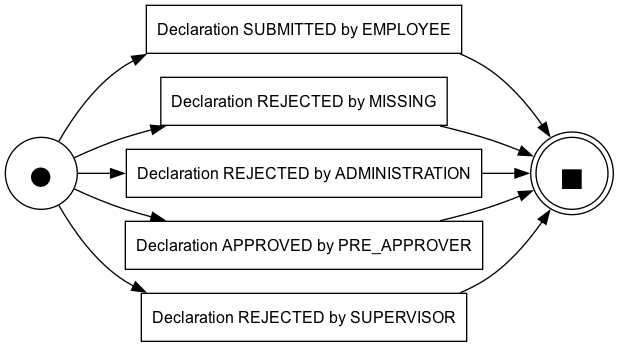


 Version: from 2018 - Cluster 1


replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

14 events, 7 cases


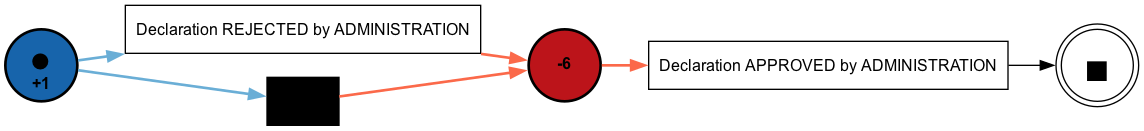


 Version: before 2018 - Cluster 1
4 events, 2 cases


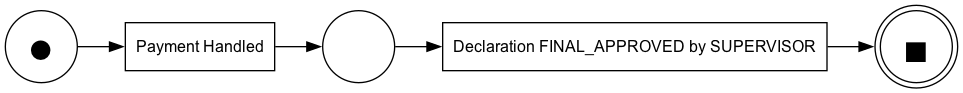









 Version: full span - Cluster 2


replaying log with TBR, completed traces ::   0%|          | 0/11 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/11 [00:00<?, ?it/s]

206 events, 192 cases


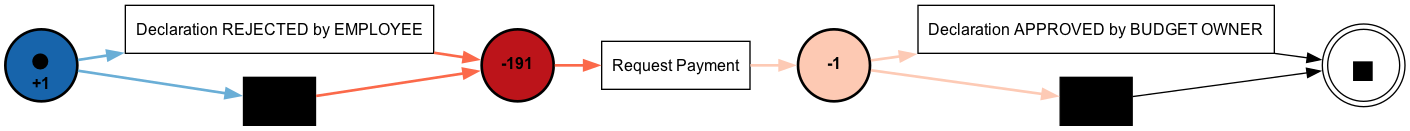


 Version: from 2018 - Cluster 2


replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

10 events, 5 cases


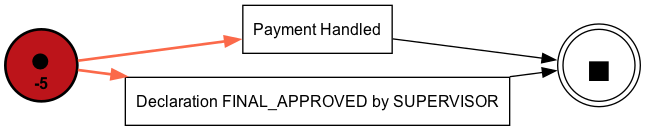


 Version: before 2018 - Cluster 2


replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

4 events, 2 cases


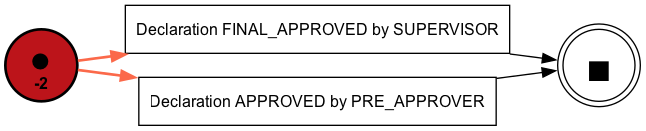









 Version: full span - Cluster 3


replaying log with TBR, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

188 events, 182 cases


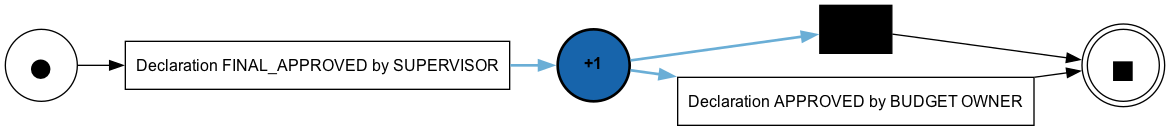


 Version: from 2018 - Cluster 3


replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

8 events, 4 cases


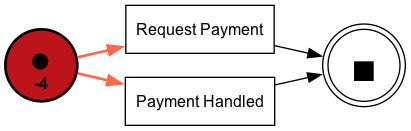


 Version: before 2018 - Cluster 3


replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

4 events, 2 cases


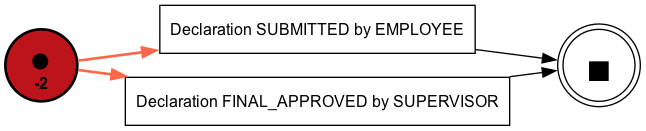









 Version: full span - Cluster 4


replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

177 events, 168 cases


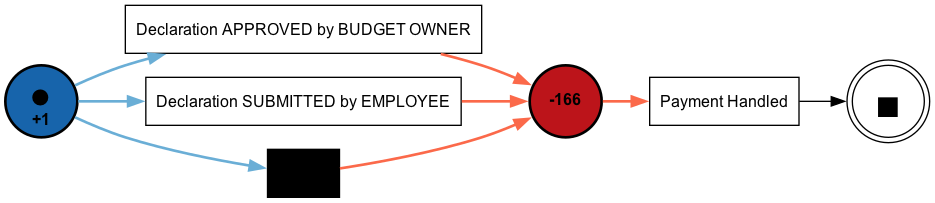


 Version: from 2018 - Cluster 4


replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

8 events, 4 cases


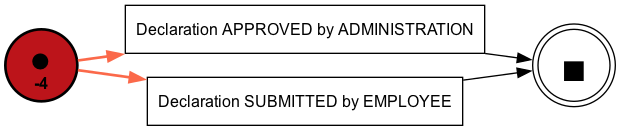


 Version: before 2018 - Cluster 4


replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

4 events, 2 cases


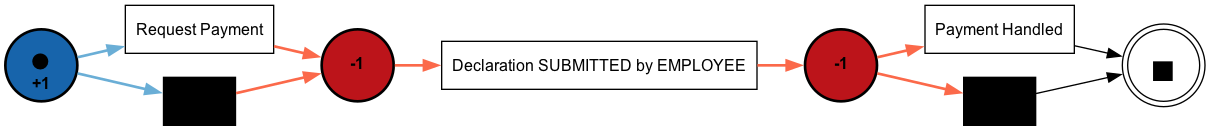









 Version: full span - Cluster 5


replaying log with TBR, completed traces ::   0%|          | 0/8 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/8 [00:00<?, ?it/s]

149 events, 139 cases


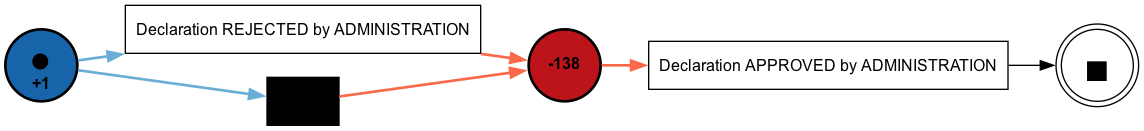


 Version: from 2018 - Cluster 5


replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/4 [00:00<?, ?it/s]

8 events, 4 cases


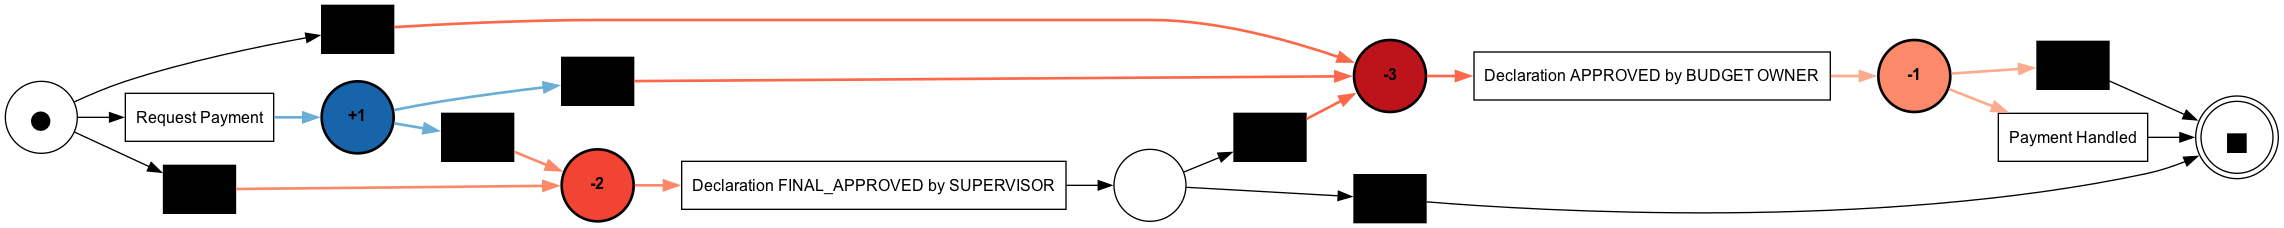


 Version: before 2018 - Cluster 5
2 events, 1 cases


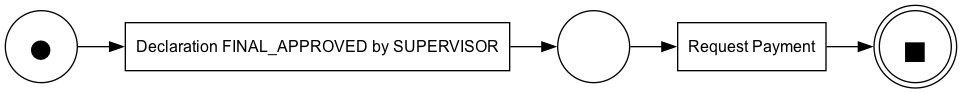









 Version: full span - Cluster 6
35 events, 35 cases


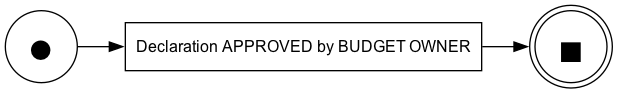


 Version: from 2018 - Cluster 6


replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/3 [00:00<?, ?it/s]

6 events, 3 cases


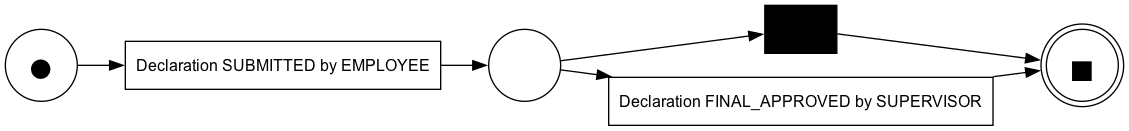


 Version: before 2018 - Cluster 6
2 events, 1 cases


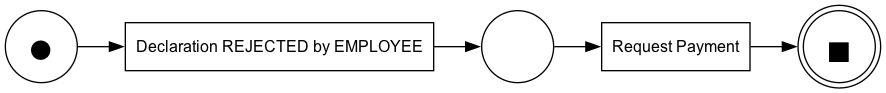









 Version: full span - Cluster 7
26 events, 26 cases


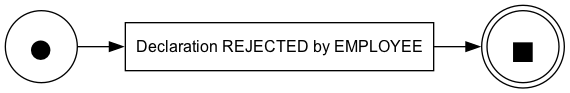


 Version: from 2018 - Cluster 7


replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/2 [00:00<?, ?it/s]

4 events, 2 cases


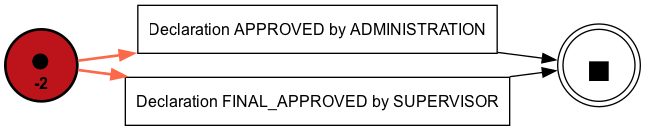

In [14]:
# Petrinets
for x in range(len(step3[0]["clusters"])):
    for j, log in enumerate(LOG_VERSIONS):
        if len(step3[j]["clusters"]) > x:
            version_print(j, description=str(x + 1))
            visualize_single_log(_cluster=step3[j]["sublogs"], df=step3[j]["clusters"][x])
    print("\n\n\n\n\n\n")